In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [25]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''

    b = 0.3  # banana bend
    a = 1.0   # масштаб
    def logp_banana(x):
        x1, x2 = x[0], x[1]
        y1 = x1 / a
        y2 = x2 + b * (x1**2 - a**2)

        return -0.5 * (y1**2 + y2**2)
    
    def grad_logp_banana(x):
        x1, x2 = x[0], x[1]
        y1 = x1 / a
        y2 = x2 + b * (x1**2 - a**2)
        # dlogp/dx2 = -y2
        d2 = -y2
        # dlogp/dx1 = -(y1/a) - 2*b*x1*y2
        d1 = -(y1/a) - 2*b*x1*y2
        return np.array([d1, d2])
    return logp_banana, grad_logp_banana

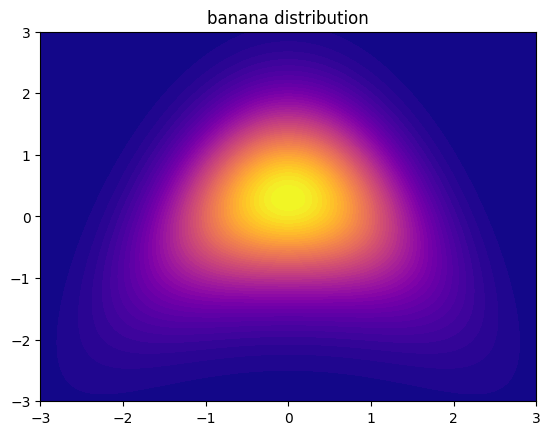

In [26]:
import matplotlib.pyplot as plt
logp_banana, _ = your_data_utils(None)
X, Y = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
Z = np.array([[np.exp(logp_banana(np.array([x, y]))) for x in X[0]] for y in Y[:,0]])
plt.contourf(X, Y, Z, levels=50, cmap='plasma')
plt.title('banana distribution')
plt.show()


In [27]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [29]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [30]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad = grad_logp(x)

        mean = x + step * grad
        prop = mean + np.sqrt(2 * step) * rng.normal(size=d)

        grad_prop = grad_logp(prop)
        mean_back = prop + step * grad_prop

        logp_prop = logp(prop)
        logp_x = logp(x)

        log_q_fwd = -0.5 * np.sum((prop - mean)**2) / (2 * step)
        log_q_bwd = -0.5 * np.sum((x - mean_back)**2) / (2 * step)

        log_alpha = (logp_prop - logp_x) + (log_q_bwd - log_q_fwd)
        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps


In [31]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3

mala_step = 0.6
mh_scale = 0.7

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_chain = mh_chain[burn:]
mala_chain = mala_chain[burn:]

ess_mh = [ess(mh_chain[:, i]) for i in range(d)]
ess_mala = [ess(mala_chain[:, i]) for i in range(d)]

print(f"MH acceptance rate:   {mh_acc:.3f}")
print(f"MALA acceptance rate: {mala_acc:.3f}")
print(f"Median ESS (MH):      {np.median(ess_mh):.1f}")
print(f"Median ESS (MALA):    {np.median(ess_mala):.1f}")


MH acceptance rate:   0.297
MALA acceptance rate: 0.618
Median ESS (MH):      783.2
Median ESS (MALA):    6489.9


In [32]:
# for step_try in [0.3, 0.4, 0.5, 0.6, 0.7]:
#     _, acc = mala(x0, 5000, step=step_try)
#     print(step_try, round(acc, 3))


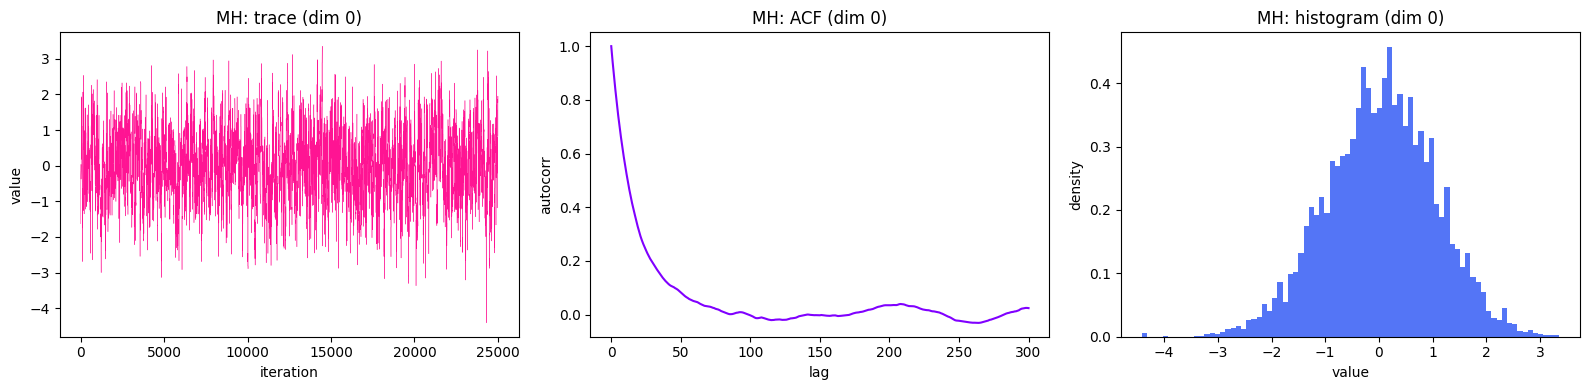

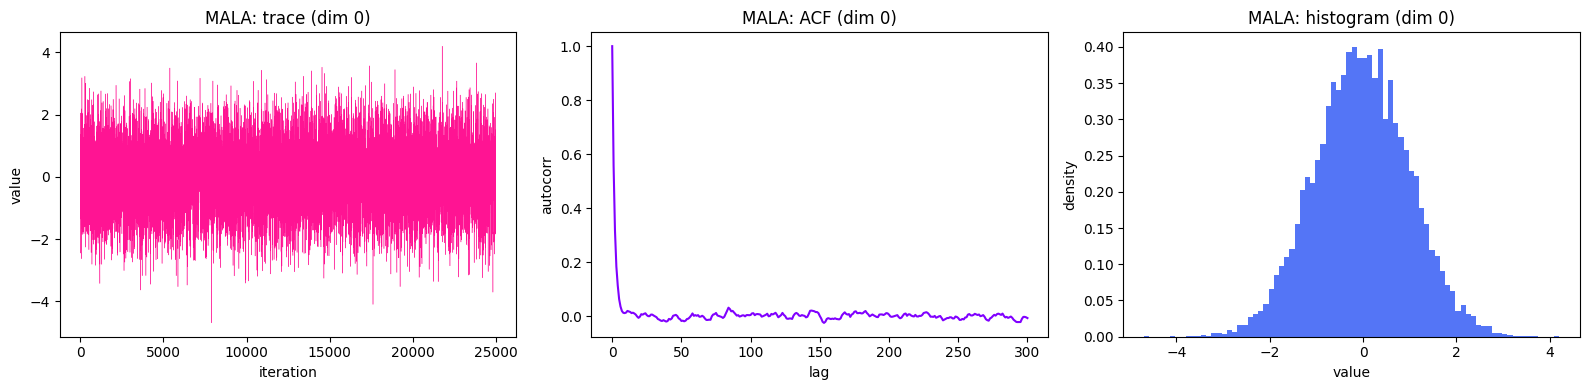

In [33]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt
import numpy as np

def plot_trace_acf_hist(samples, title=''):
    x = samples[:, 0]  
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    ax[0].plot(x, color="#FF1493", lw=0.3)
    ax[0].set_title(f'{title}: trace (dim 0)', fontsize=12)
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('value')

    x0 = x - x.mean()
    acf = np.correlate(x0, x0, mode='full')
    acf = acf[acf.size // 2:]
    acf /= acf[0]
    maxlag = min(300, len(x)-1)
    ax[1].plot(np.arange(maxlag+1), acf[:maxlag+1], color="#8000FF")
    ax[1].set_title(f'{title}: ACF (dim 0)', fontsize=12)
    ax[1].set_xlabel('lag')
    ax[1].set_ylabel('autocorr')

    ax[2].hist(x, bins=80, density=True, color="#4166f5", alpha=0.9)
    ax[2].set_title(f'{title}: histogram (dim 0)', fontsize=12)
    ax[2].set_xlabel('value')
    ax[2].set_ylabel('density')

    plt.tight_layout()
    plt.show()

plot_trace_acf_hist(mh_chain,   title='MH')
plot_trace_acf_hist(mala_chain, title='MALA')



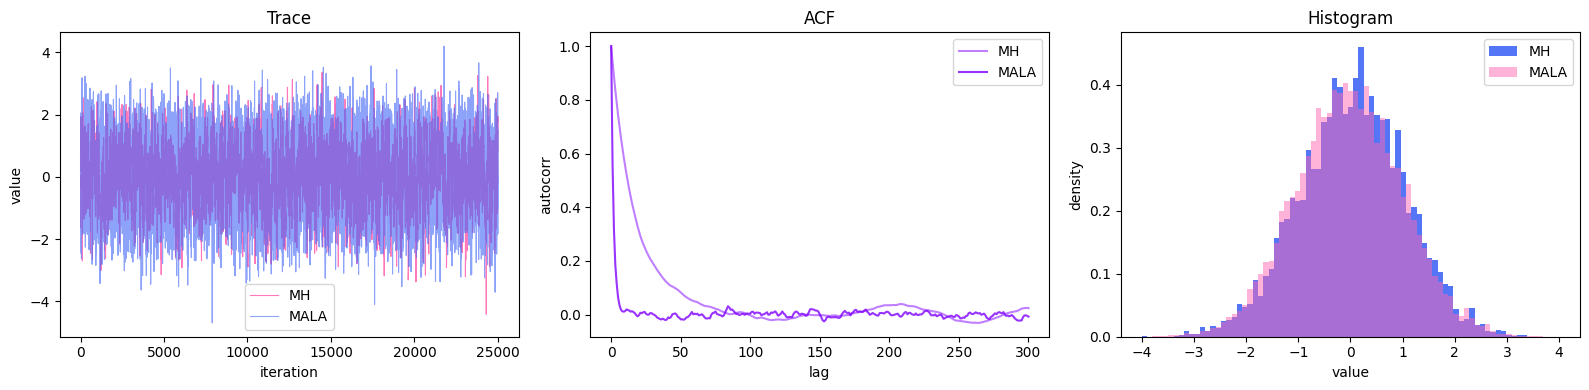

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_mh_mala(mh_chain, mala_chain):
    x_mh = mh_chain[:, 0]
    x_mala = mala_chain[:, 0]

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    ax[0].plot(x_mh, color="#FF69B4", alpha=0.9, lw=0.8, label='MH')
    ax[0].plot(x_mala, color="#4166F5", alpha=0.6, lw=0.8, label='MALA')
    ax[0].set_title('Trace')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('value')
    ax[0].legend()

    def compute_acf(x):
        x0 = x - x.mean()
        acf = np.correlate(x0, x0, mode='full')
        acf = acf[acf.size // 2:]
        acf /= acf[0]
        return acf

    acf_mh = compute_acf(x_mh)
    acf_mala = compute_acf(x_mala)
    maxlag = min(300, len(x_mh)-1)
    ax[1].plot(np.arange(maxlag+1), acf_mh[:maxlag+1], color="#8000FF", alpha=0.5, lw=1.5, label='MH')
    ax[1].plot(np.arange(maxlag+1), acf_mala[:maxlag+1], color="#8000FF", alpha=0.8, lw=1.5, label='MALA')
    ax[1].set_title('ACF')
    ax[1].set_xlabel('lag')
    ax[1].set_ylabel('autocorr')
    ax[1].legend()

    bins = np.linspace(-4, 4, 80)
    ax[2].hist(x_mh, bins=bins, density=True, color="#4166F5", alpha=0.9, label='MH')
    ax[2].hist(x_mala, bins=bins, density=True, color="#FF69B4", alpha=0.5, label='MALA')
    ax[2].set_title('Histogram')
    ax[2].set_xlabel('value')
    ax[2].set_ylabel('density')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

overlay_mh_mala(mh_chain, mala_chain)


- у mala траектория плотнее заполняет пространство, меньше рывков и пауз, цепь перемешивается быстрее, значит алгоритм эффективнее перемещается по пространству распределения

- автокорреляция у mala падает заметно быстрее, эффективный размер выборки выше, значит выборка содержит больше независимой информации

- гистограммы почти совпадают, но mala достигает той же формы быстрее и стабильнее, значит метод лучше приближает истинное распределение за то же число итераций